<a href="https://colab.research.google.com/github/sayaliKutwal/image-classifier-using-pytorch/blob/master/Image_Classifier_Lab_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#map my google drive to colab 
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# http://pytorch.org/  Install pytorch
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision


In [0]:
# Imports here
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import json 
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

#import  pil extensions
from PIL import Image
def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
Image.register_extension = register_extension
def register_extensions(id, extensions): 
  for extension in extensions: register_extension(id, extension)
Image.register_extensions = register_extensions

!pip install pillow==4.1.1
%reload_ext autoreload
%autoreload

import PIL
print(PIL.PILLOW_VERSION)
!pip uninstall Pillow
!pip install Pillow==5.3.0


plt.ion()   # interactive mode


  Using cached https://files.pythonhosted.org/packages/36/e5/88b3d60924a3f8476fa74ec086f5fbaba56dd6cee0d82845f883b6b6dd18/Pillow-4.1.1-cp36-cp36m-manylinux1_x86_64.whl
  Found existing installation: Pillow 5.3.0
    Uninstalling Pillow-5.3.0:
      Successfully uninstalled Pillow-5.3.0
5.3.0
Uninstalling Pillow-4.1.1:
  Would remove:
    /usr/local/bin/createfontdatachunk.py
    /usr/local/bin/enhancer.py
    /usr/local/bin/explode.py
    /usr/local/bin/gifmaker.py
    /usr/local/bin/painter.py
    /usr/local/bin/pilconvert.py
    /usr/local/bin/pildriver.py
    /usr/local/bin/pilfile.py
    /usr/local/bin/pilfont.py
    /usr/local/bin/pilprint.py
    /usr/local/bin/player.py
    /usr/local/bin/thresholder.py
    /usr/local/bin/viewer.py
    /usr/local/lib/python3.6/dist-packages/PIL/*
    /usr/local/lib/python3.6/dist-packages/Pillow-4.1.1.dist-info/*
Proceed (y/n)? y
  Successfully uninstalled Pillow-4.1.1
  Using cached https://files.pythonhosted.org/packages/62/94/5430ebaa83f91cc7a

In [0]:

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/gdrive/My Drive/Colab Notebooks/pytorch_challenge-master/flower_data'
train = data_dir + '/train'
valid = data_dir + '/valid'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'valid']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}

#class_names = image_datasets['train'].classes


with open('/content/gdrive/My Drive/Colab Notebooks/pytorch_challenge-master/cat_to_name.json', 'r') as f:
  cat_to_name = json.load(f)
  
class_to_idx = image_datasets['train'].class_to_idx

#index to class number
#idx_to_class = {class_to_idx[k]: k for k in class_to_idx}
def idx_to_class_number(idx):
  return next(k for k, v in class_to_idx.items() if v == idx)
  cat_to_name[idx_to_class_number(idx)]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


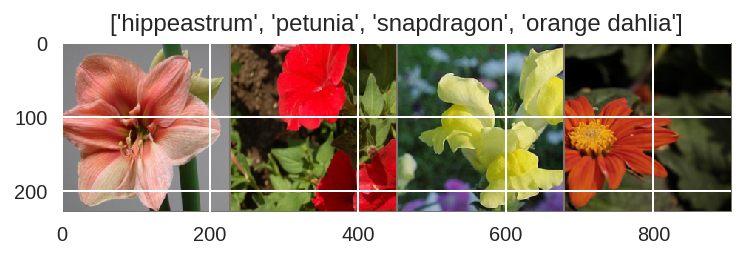

In [0]:
#Visualizing some images
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
    
imshow(out, title=[cat_to_name[idx_to_class_number(idx)] for idx in classes])



In [0]:
#Training the model

def train_model(model, criterion, optimizer, scheduler, num_epochs=30):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [0]:
#Visualizing the model predictions

#class to idx
def idx_to_class_number(idx):
                  return next(k for k, v in class_to_idx.items() if v == idx)

def visualize_model(model, num_images=2):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['valid']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')                
                title_name = cat_to_name[idx_to_class_number(preds[j])]                 
                ax.set_title('predicted: {}'.format(title_name))
                
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


In [0]:
#finetuning the convnet
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 102)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)



In [0]:
#Train and Evaluate
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=40)
torch.save(model_ft.state_dict(),'/content/gdrive/My Drive/classifier.pt')

Epoch 0/39
----------
train Loss: 2.6115 Acc: 0.4084
valid Loss: 0.6320 Acc: 0.8215

Epoch 1/39
----------
train Loss: 1.2524 Acc: 0.6818
valid Loss: 0.3155 Acc: 0.9071

Epoch 2/39
----------
train Loss: 0.9399 Acc: 0.7665
valid Loss: 0.2423 Acc: 0.9267

Epoch 3/39
----------
train Loss: 0.8006 Acc: 0.7998
valid Loss: 0.2577 Acc: 0.9328

Epoch 4/39
----------
train Loss: 0.7054 Acc: 0.8217
valid Loss: 0.1900 Acc: 0.9511

Epoch 5/39
----------
train Loss: 0.6397 Acc: 0.8347
valid Loss: 0.1782 Acc: 0.9523

Epoch 6/39
----------
train Loss: 0.5968 Acc: 0.8492
valid Loss: 0.1834 Acc: 0.9462

Epoch 7/39
----------
train Loss: 0.4381 Acc: 0.8880
valid Loss: 0.1357 Acc: 0.9658

Epoch 8/39
----------
train Loss: 0.3555 Acc: 0.9190
valid Loss: 0.1072 Acc: 0.9743

Epoch 9/39
----------
train Loss: 0.3484 Acc: 0.9150
valid Loss: 0.1207 Acc: 0.9682

Epoch 10/39
----------
train Loss: 0.3352 Acc: 0.9208
valid Loss: 0.1287 Acc: 0.9621

Epoch 11/39
----------
train Loss: 0.3578 Acc: 0.9132
valid Loss

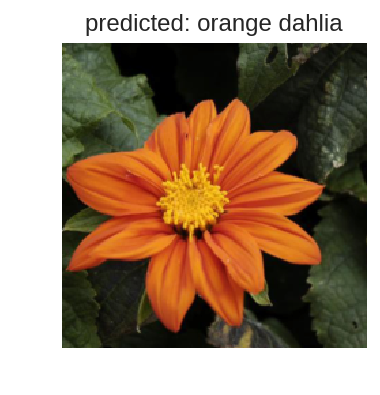

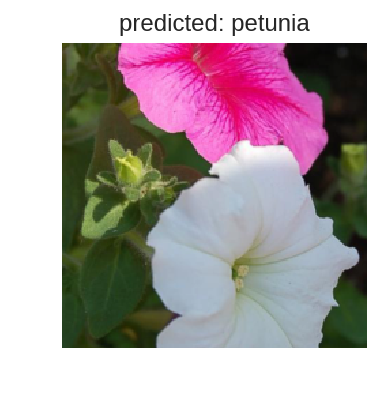

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f073abec908>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.6/dist-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/usr/lib/python3.6/multiprocessing/resource_sharer.py", line 87, in get_connection
    c = Client(address, authkey=process.current_process().authkey)
  Fil

In [0]:
#Visualizing the model
visualize_model(model_ft)

In [0]:
#Convnet as fixed feature extractor
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 102)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [0]:
#Train and evaluate
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=40)

Epoch 0/39
----------
train Loss: 3.2395 Acc: 0.2964
valid Loss: 1.3148 Acc: 0.6883

Epoch 1/39
----------
train Loss: 1.9999 Acc: 0.5525
valid Loss: 0.7779 Acc: 0.8044

Epoch 2/39
----------
train Loss: 1.5860 Acc: 0.6319
valid Loss: 0.5662 Acc: 0.8716

Epoch 3/39
----------
train Loss: 1.3584 Acc: 0.6809
valid Loss: 0.4413 Acc: 0.8851

Epoch 4/39
----------
train Loss: 1.2261 Acc: 0.7053
valid Loss: 0.4471 Acc: 0.8814

Epoch 5/39
----------
train Loss: 1.1567 Acc: 0.7216
valid Loss: 0.3675 Acc: 0.9059

Epoch 6/39
----------
train Loss: 1.0340 Acc: 0.7553
valid Loss: 0.3342 Acc: 0.9205

Epoch 7/39
----------
train Loss: 1.0390 Acc: 0.7549
valid Loss: 0.3482 Acc: 0.9144

Epoch 8/39
----------
train Loss: 0.9916 Acc: 0.7686
valid Loss: 0.3308 Acc: 0.9181

Epoch 9/39
----------
train Loss: 0.9848 Acc: 0.7718
valid Loss: 0.3301 Acc: 0.9108

Epoch 10/39
----------
train Loss: 0.9941 Acc: 0.7698
valid Loss: 0.2939 Acc: 0.9279

Epoch 11/39
----------
train Loss: 0.9756 Acc: 0.7782
valid Loss

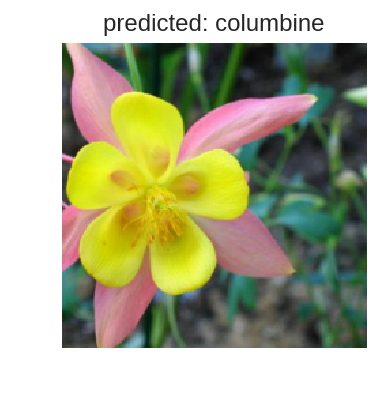

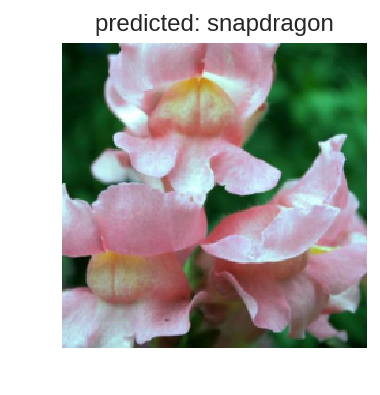

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f0734041d68>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.6/dist-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/usr/lib/python3.6/multiprocessing/resource_sharer.py", line 87, in get_connection
    c = Client(address, authkey=process.current_process().authkey)
  Fil

In [0]:
#Visualize model
visualize_model(model_conv)

plt.ioff()
plt.show()

In [0]:
#Saving model 
#model_save_name = 'classifier.pt'
#path = '/content/gdrive/My Drive/Colab Notebooks/{model_save_name}' 
#torch.save(model.state_dict(), '/content/gdrive/My Drive/classifier.pt')
#checkpoint = torch.load('/content/gdrive/My Drive/classifier.pt', map_location = 'cpu')
#model.load_state_dict(checkpoint['state_dict'], strict = False)

#model = models.resnet18(pretrained=True)
#num_ftrs = model.fc.in_features
#model.fc = nn.Linear(num_ftrs, 102)
#for param in model.parameters():
 #   param.requires_grad = False
  
#model_conv = torchvision.models.resnet18(pretrained=True)
#num_ftrs = model_conv.fc.in_features
#model_conv.fc = nn.Linear(num_ftrs, 102)
#for param in model_conv.parameters():
#    param.requires_grad = False  
#model_conv.load_state_dict(torch.load('/content/gdrive/My Drive/classifier.pt', map_location = 'cpu'), strict = False)
#torch.save(model_conv.state_dict(), '/content/gdrive/My Drive/classifier.pt')

NameError: ignored